In [20]:
# setup Pytorch env
import os
os.environ['TORCH_HOME']="/home/alex/data/pytorch"

from matplotlib import pyplot as plt
import collections
import datetime

import torch.nn.functional as F
import torchvision as torchv
import torch as torch
import PIL as pil

# 08. Using convolutions to generalize
In the previous chapter, we built a simple neural network that could fit (or overfit) the data, thanks to the many parameters available for optimization in the linear layers. We had issues with our model, however, in that it was better at memorizing the training set than it was at generalizing properties of birds and airplanes. Based on our model architecture, we’ve got a guess as to why that’s the case. Due to the fully connected setup needed to detect the various possible translations of the bird or airplane in the image, we have both too many parameters (making it easier for the model to memorize the training set) and no position independence (making it harder to generalize). As we discussed in the last chapter, we could augment our training data by using a wide variety of recropped images to try to force generalization, but that won’t address the issue of having too many parameters.

There is a better way! It consists of replacing the dense, fully connected affine transformation in our neural network unit with a different linear operation: **convolution**.

## 8.1 The case for convolutions
Let’s get to the bottom of what convolutions are and how we can use them in our neural networks. 

In this section, we’ll see how convolutions deliver locality and translation invariance. We’ll do so by taking a close look at the formula defining convolutions and applying it using pen and paper—but don’t worry, the gist will be in pictures, not formulas.

We said earlier that taking a 1D view of our input image and multiplying it by an $\textit{n_output_features} × \textit{n_input_features}$ weight matrix, as is done in `nn.Linear`, means for each channel in the image, computing a weighted sum of all the pixels multiplied by a set of weights, one per output feature.

We also said that, if we want to recognize patterns corresponding to objects, like an airplane in the sky, we will likely need to look at how nearby pixels are arranged, and we will be less interested in how pixels that are far from each other appear in combination. Essentially, it doesn’t matter if our image of a Spitfire has a tree or cloud or kite in the corner or not.

In order to translate this intuition into mathematical form, we could compute the weighted sum of a pixel with its immediate neighbors, rather than with all other pixels in the image. This would be equivalent to building weight matrices, one per output feature and output pixel location, in which all weights beyond a certain distance from a center pixel are zero. This will still be a weighted sum: that is, a linear operation.

### 8.1.1 What convolutions do
We identified one more desired property earlier: we would like these localized patterns to have an effect on the output regardless of their location in the image: that is, to be translation invariant. To achieve this goal in a matrix applied to the image-as-a-vector we used in chapter 7 would require implementing a rather complicated pattern of weights (don’t worry if it is too complicated; it’ll get better shortly): most of the weight matrix would be zero (for entries corresponding to input pixels too far away from the output pixel to have an influence). For other weights, we would have to find a way to keep entries in sync that correspond to the same relative position of input and output pixels. This means we would need to initialize them to the same values and ensure that all these tied weights stayed the same while the network is updated during training. This way, we would ensure that weights operate in neighborhoods to respond to local patterns, and local patterns are identified no matter where they occur in the image.

Of course, this approach is more than impractical. Fortunately, there is a readily available, local, translation-invariant linear operation on the image: a *convolution*. We can come up with a more compact description of a convolution, but what we are going to describe is exactly what we just delineated—only taken from a different angle.

Convolution, or more precisely, *discrete convolution* (there’s an analogous continuous version that we won’t go into here), is defined for a 2D image as the scalar product of a weight matrix, the kernel, with every neighborhood in the input. Consider a $3 × 3$ kernel (in deep learning, we typically use small kernels; we’ll see why later on) as a 2D tensor:

```python
weight = torch.tensor([
    [w00, w01, w02], 
    [w10, w11, w12],
    [w20, w21, w22]])
```

and a $1$-channel, $M \times N$ image:

```python
image = torch.tensor([
    [i00, i01, i02, i03, ..., i0N],
    [i10, i11, i12, i13, ..., i1N],
    [i20, i21, i22, i23, ..., i2N],
    [i30, i31, i32, i33, ..., i3N], 
    #...
    [iM0, iM1m iM2, iM3, ..., iMN]])
```

We can compute an element of the output image (without bias) as follows:

```python
o11 = i11 * w00 + i12 * w01 + i22 * w02 + 
        i21 * w10 + i22 * w11 + i23 * w12 + 
        i31 * w20 + i32 * w21 + i33 * w22
```

`Figure 8.1` shows this computation in action.

That is, we "translate" the kernel on the $i11$ location of the input image, and we multiply each weight by the value of the input image at the corresponding location. Thus, the output image is created by translating the kernel on all input locations and performing the weighted sum. For a multichannel image, like our `RGB` image, the weight matrix would be a $3 × 3 × 3$ matrix: one set of weights for every channel, contributing together to the output values.

Note that, just like the elements in the weight matrix of `nn.Linear`, the weights in the kernel are not known in advance, but they are initialized randomly and updated through backpropagation. Note also that the same kernel, and thus each weight in the kernel, is reused across the whole image. Thinking back to autograd, this means the use of each weight has a history spanning the entire image. Thus, the derivative of the loss with respect to a convolution weight includes contributions from the entire image.

<img src="images/08_01.png" style="width:600px;"/>

It’s now possible to see the connection to what we were stating earlier: a convolution is equivalent to having multiple linear operations whose weights are zero almost everywhere except around individual pixels and that receive equal updates during training.

Summarizing, by switching to convolutions, we get:
+ Local operations on neighborhoods  
+ Translation invariance  
+ Models with a lot fewer parameters

The key insight underlying the third point is that, with a convolution layer, the number of parameters depends not on the number of pixels in the image, as was the case in our fully connected model, but rather on the size of the convolution kernel ($3 × 3$, $5 × 5$, and so on) and on how many convolution filters (or output channels) we decide to use in our model.

## 8.2 Convolutions in action
Well, it looks like we’ve spent enough time down a rabbit hole! Let’s see some `PyTorch` in action on our birds versus airplanes challenge. The `torch.nn` module provides convolutions for $1$, $2$, and $3$ dimensions: 
+ `nn.Conv1d` for time series
+ `nn.Conv2d` for images
+ `nn.Conv3d` for volumes or videos

For our `CIFAR-10` data, we’ll resort to `nn.Conv2d`. At a minimum, the arguments we provide to `nn.Conv2d` are:
+ the number of input features (or channels, since we’re dealing with multichannel images: that is, more than one value per pixel)
+ the number of output features
+ the size of the kernel

For instance, for our first convolutional module, we’ll have $3$ input features per pixel (the RGB channels) and an arbitrary number of channels in the output—say, $16$. The more channels in the output image, the more the capacity of the network. We need the channels to be able to detect many different types of features. Also, because we are randomly initializing them, some of the features we’ll get, even after training, will turn out to be useless. Let’s stick to a kernel size of $3 × 3$.

It is very common to have kernel sizes that are the same in all directions, so `PyTorch` has a shortcut for this: whenever `kernel_size=3` is specified for a 2D convolution, it means $3 × 3$ (provided as a tuple $(3, 3)$ in Python). For a 3D convolution, it means $3 × 3 × 3$. The CT scans we will see in part 2 of the book have a different voxel (volumetric pixel) resolution in one of the three axes. In such a case, it makes sense to consider kernels that have a different size for the exceptional dimension. But for now, we stick with having the same size of convolutions across all dimensions:

In [2]:
# Instead of the shortcut kernel_size=3, we could equivalently pass in the tuple that we see 
# in the output: kernel_size=(3, 3).
conv = torch.nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

What do we expect to be the shape of the weight tensor? The kernel is of size $3 × 3$, so we want the weight to consist of $3 × 3$ parts. For a single output pixel value, our kernel would consider, say, $\textit{in_ch} = 3$ input channels, so the weight component for a single output pixel value (and by translation the invariance for the entire output channel) is of shape $\textit{in_ch} × 3 × 3$. Finally, we have as many of those as we have output channels, here $\textit{out_ch} = 16$, so the complete weight tensor is $\textit{out_ch} × \textit{in_ch} × 3 × 3$, in our case $16 × 3 × 3 × 3$. The bias will have size $16$ (we haven’t talked about bias for a while for simplicity, but just as in the linear module case, it’s a constant value we add to each channel of the output image). Let’s verify our assumptions:

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

We can see how convolutions are a convenient choice for learning from images. We have smaller models looking for local patterns whose weights are optimized across the entire image.

A 2D convolution pass produces a 2D image as output, whose pixels are a weighted sum over neighborhoods of the input image. In our case, both the kernel weights and the bias `conv.weight` are initialized randomly, so the output image will not be particularly meaningful. As usual, we need to add the zeroth batch dimension with unsqueeze if we want to call the `conv` module with one input image, since `nn.Conv2d` expects a $B × C × H × W$ shaped tensor as input:

In [4]:
# Instantiates a dataset for the training data; 
# TorchVision downloads the data if it is not present.
data_path = os.environ['TORCH_HOME'] + '/cifar_10/'

cifar10 = torchv.datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=torchv.transforms.Compose([
        torchv.transforms.ToTensor(),
        torchv.transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = torchv.datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=torchv.transforms.Compose([
        torchv.transforms.ToTensor(),
        torchv.transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ]))

label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) 
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

We’re curious, so we can display the output.

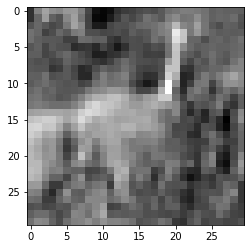

In [5]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Wait a minute. Let’s take a look a the size of output: it’s `torch.Size([1, 16, 30, 30])`. Huh; we lost a few pixels in the process. How did that happen?

### 8.2.1 Padding the boundary
The fact that our output image is smaller than the input is a side effect of deciding what to do at the boundary of the image. Applying a convolution kernel as a weighted sum of pixels in a $3 × 3$ neighborhood requires that there are neighbors in all directions. If we are at $i00$, we only have pixels to the right of and below us. By default, `PyTorch` will slide the convolution kernel within the input picture, getting $\textit{width} - \textit{kernel_width} + 1$ horizontal and vertical positions. For odd-sized kernels, this results in images that are one-half the convolution kernel’s width (in our case, $\frac{3}{2} = 1$) smaller on each side. This explains why we’re missing two pixels in each dimension.

However, `PyTorch` gives us the possibility of padding the image by creating ghost pixels around the border that have value zero as far as the convolution is concerned. `Figure 8.3` shows padding in action.

<img src="images/08_03.png" style="width:600px;"/>

In our case, specifying $\textit{padding}=1$ when $\textit{kernel_size}=3$ means $i00$ has an extra set of neighbors above it and to its left, so that an output of the convolution can be computed even in the corner of our original image. The net result is that the output has now the exact same size as the input:

In [6]:
conv = torch.nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0)) 
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

Note that the sizes of weight and bias don’t change, regardless of whether padding is used.

There are two main reasons to pad convolutions. First, doing so helps us separate the matters of convolution and changing image sizes, so we have one less thing to remember. And second, when we have more elaborate structures such as skip connections (discussed in `section 8.5.3`) or the `U-Nets` we’ll cover in `part 2`, we want the tensors before and after a few convolutions to be of compatible size so that we can add them or take differences.

### 8.2.2 Detecting features with convolutions
We said earlier that weight and bias are parameters that are learned through backpropagation, exactly as it happens for weight and bias in `nn.Linear`. However, we can play with convolution by setting weights by hand and see what happens.

Let’s first zero out bias, just to remove any confounding factors, and then set weights to a constant value so that each pixel in the output gets the mean of its neighbors. For each $3 × 3$ neighborhood:

In [7]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

We could have gone with `conv.weight.one_()`—that would result in each pixel in the output being the sum of the pixels in the neighborhood. Not a big difference, except that the values in the output image would have been nine times larger.

Anyway, let’s see the effect on our `CIFAR` image:

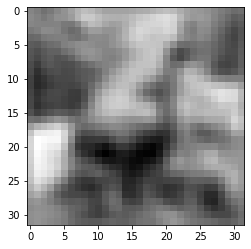

In [8]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

As we could have predicted, the filter produces a blurred version of the image. After all, every pixel of the output is the average of a neighborhood of the input, so pixels in the output are correlated and change more smoothly.

Next, let’s try something different. The following kernel may look a bit mysterious at first:

In [9]:
conv = torch.nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

Working out the weighted sum for an arbitrary pixel in position $2,2$, as we did earlier for the generic convolution kernel, we get:
$o22 = i13 - i11 + i23 - i21 + i33 - i31$

which performs the difference of all pixels on the right of $i22$ minus the pixels on the left of $i22$. If the kernel is applied on a vertical boundary between two adjacent regions of different intensity, $o22$ will have a high value. If the kernel is applied on a region of uniform intensity, $o22$ will be zero. It’s an edge-detection kernel: the kernel highlights the vertical edge between two horizontally adjacent regions.

Applying the convolution kernel to our image, we see the result shown in `figure 8.5`. As expected, the convolution kernel enhances the vertical edges. We could build lots more elaborate filters, such as for detecting horizontal or diagonal edges, or crosslike or checkerboard patterns, where "detecting" means the output has a high magnitude. In fact, the job of a computer vision expert has historically been to come up with the most effective combination of filters so that certain features are highlighted in images and objects can be recognized.

<img src="images/08_05.png" style="width:600px;"/>

With deep learning, we let kernels be estimated from data in whatever way the discrimination is most effective: for instance, in terms of minimizing the negative crossentropy loss between the output and the ground truth that we introduced in `section 7.2.5`. From this angle, the job of a convolutional neural network is to estimate the kernel of a set of filter banks in successive layers that will transform a multichannel image into another multichannel image, where different channels correspond to different features (such as one channel for the average, another channel for vertical edges, and so on). `Figure 8.6` shows how the training automatically learns the kernels.

<img src="images/08_06.png" style="width:600px;"/>

### 8.2.3 Looking further with depth and pooling
This is all well and good, but conceptually there’s an elephant in the room. We got all excited because by moving from fully connected layers to convolutions, we achieve locality and translation invariance. Then we recommended the use of small kernels, like $3 × 3$, or $5 × 5$: that’s peak locality, all right. What about the big picture? How do we know that all structures in our images are $3$ pixels or $5$ pixels wide? Well, we don’t, because they aren’t. And if they aren’t, how are our networks going to be equipped to see those patterns with larger scope? This is something we’ll really need if we want to solve our birds versus airplanes problem effectively, since although `CIFAR-10` images are small, the objects still have a (wing-)span several pixels across.

One possibility could be to use large convolution kernels. Well, sure, at the limit we could get a $32 × 32$ kernel for a $32 × 32$ image, but we would converge to the old fully connected, affine transformation and lose all the nice properties of convolution. Another option, which is used in convolutional neural networks, is stacking one convolution after the other and at the same time downsampling the image between successive convolutions.

##### FROM LARGE TO SMALL: DOWNSAMPLING
Downsampling could in principle occur in different ways. Scaling an image by half is the equivalent of taking four neighboring pixels as input and producing one pixel as output. How we compute the value of the output based on the values of the input is up to us. We could:
+ *Average the four pixels*. This average pooling was a common approach early on but has fallen out of favor somewhat.
+ *Take the maximum of the four pixels*. This approach, called max pooling, is currently the most commonly used approach, but it has a downside of discarding the other three-quarters of the data.
+ *Perform a strided convolution, where only every $N$-th pixel is calculated*. A $3 × 4$ convolution with stride $2$ still incorporates input from all pixels from the previous layer. The literature shows promise for this approach, but it has not yet supplanted max pooling.

We will be focusing on max pooling, illustrated in `figure 8.7`, going forward. The figure shows the most common setup of taking non-overlapping $2 x 2$ tiles and taking the maximum over each of them as the new pixel at the reduced scale.

<img src="images/08_07.png" style="width:500px;"/>

Intuitively, the output images from a convolution layer, especially since they are followed by an activation just like any other linear layer, tend to have a high magnitude where certain features corresponding to the estimated kernel are detected (such as vertical lines). By keeping the highest value in the $2 × 2$ neighborhood as the downsampled output, we ensure that the features that are found survive the downsampling, at the expense of the weaker responses.

Max pooling is provided by the `nn.MaxPool2d` module (as with convolution, there are versions for 1D and 3D data). It takes as input the size of the neighborhood over which to operate the pooling operation. If we wish to downsample our image by half, we’ll want to use a size of $2$. Let’s verify that it works as expected directly on our input image:

In [10]:
pool = torch.nn.MaxPool2d(2) 
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

##### COMBINING CONVOLUTIONS AND DOWNSAMPLING FOR GREAT GOOD
Let’s now see how combining convolutions and downsampling can help us recognize larger structures. In `figure 8.8`, we start by applying a set of $3 × 3$ kernels on our $8 × 8$ image, obtaining a multichannel output image of the same size. Then we scale down the output image by half, obtaining a $4 × 4$ image, and apply another set of $3 × 3$ kernels to it. This second set of kernels operates on a $3 × 3$ neighborhood of something that has been scaled down by half, so it effectively maps back to $8 × 8$ neighborhoods of the input. In addition, the second set of kernels takes the output of the first set of kernels (features like averages, edges, and so on) and extracts additional features on top of those.

So, on one hand, the first set of kernels operates on small neighborhoods on first-order, low-level features, while the second set of kernels effectively operates on wider neighborhoods, producing features that are compositions of the previous features. This is a very powerful mechanism that provides convolutional neural networks with the ability to see into very complex scenes—much more complex than our $32 × 32$ images from the `CIFAR-10` dataset.

<img src="images/08_08.png" style="width:600px;"/>

> **The receptive field of output pixels**
>
> When the second $3 × 3$ convolution kernel produces 21 in its conv output in `figure 8.8`, this is based on the top-left $3 × 3$ pixels of the first max pool output. They, in turn, correspond to the $6 × 6$ pixels in the top-left corner in the first conv output, which in turn are computed by the first convolution from the top-left $7 × 7$ pixels. So the pixel in the second convolution output is influenced by a $7 × 7$ input square. The first convolution also uses an implicitly "padded" column and row to produce the output in the corner; otherwise, we would have an $8 × 8$ square of input pixels informing a given pixel (away from the boundary) in the second convolution’s output. In fancy language, we say that a given output neuron of the $3 × 3$-conv, $2 × 2$-max-pool, $3 × 3$-conv construction has a receptive field of $8 × 8$.

### 8.2.4 Putting it all together for our network
With these building blocks in our hands, we can now proceed to build our convolutional neural network for detecting birds and airplanes. Let’s take our previous fully connected model as a starting point and introduce `nn.Conv2d` and `nn.MaxPool2d` as described previously:

```python
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(), nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(), nn.MaxPool2d(2), 
    # ...
)
```

The first convolution takes us from $3$ RGB channels to $16$, thereby giving the network a chance to generate $16$ independent features that operate to (hopefully) discriminate low-level features of birds and airplanes. Then we apply the `Tanh` activation function. The resulting $16$-channel $32 × 32$ image is pooled to a $16$-channel $16 × 16$ image by the first `MaxPool2d(2)`. At this point, the downsampled image undergoes another convolution that generates an $8$-channel $16 × 16$ output. With any luck, this output will consist of higher-level features. Again, we apply a `Tanh` activation and then pool to an $8$-channel $8 × 8$ output.

Where does this end? After the input image has been reduced to a set of $8 × 8$ features, we expect to be able to output some probabilities from the network that we can feed to our negative log likelihood. However, probabilities are a pair of numbers in a 1D vector (one for airplane, one for bird), but here we’re still dealing with multichannel 2D features.

Thinking back to the beginning of this chapter, we already know what we need to do: turn the $8$-channel $8 × 8$ image into a 1D vector and complete our network with a set of fully connected layers:

```python
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(), nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(), nn.MaxPool2d(2), 
    # Warning: Something important is missing here!
    # ...
    nn.Linear(8 * 8 * 8, 32), 
    nn.Tanh(), 
    nn.Linear(32, 2))
```

This code gives us a neural network as shown in `figure 8.9`.

<img src="images/08_09.png" style="width:600px;"/>

Ignore the "something missing" comment for a minute. Let’s first notice that the size of the linear layer is dependent on the expected size of the output of `MaxPool2d`: $8 × 8 × 8 = 512$. Let’s count the number of parameters for this small model:

In [11]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16, kernel_size=3, padding=1),
    torch.nn.Tanh(), torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16, 8, kernel_size=3, padding=1),
    torch.nn.Tanh(), torch.nn.MaxPool2d(2), 
    # Warning: Something important is missing here!
    # ...
    torch.nn.Linear(8 * 8 * 8, 32), 
    torch.nn.Tanh(), 
    torch.nn.Linear(32, 2))

numel_list = [p.numel() for p in model.parameters()] 
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

That’s very reasonable for a limited dataset of such small images. In order to increase the capacity of the model, we could increase the number of output channels for the convolution layers (that is, the number of features each convolution layer generates), which would lead the linear layer to increase its size as well.

We put the "Warning" note in the code for a reason. The model has zero chance of running without complaining:

In [12]:
try:
    model(img.unsqueeze(0))
except Exception as err:
    print(err)

size mismatch, m1: [64 x 8], m2: [512 x 32] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:41


Admittedly, the error message is a bit obscure, but not too much so. We find references to linear in the traceback: looking back at the model, we see that only module that has to have a $512 × 32$ tensor is `nn.Linear(512, 32)`, the first linear module after the last convolution block.

What’s missing there is the reshaping step from an $8$-channel $8 × 8$ image to a $512$-element, 1D vector (1D if we ignore the batch dimension, that is). This could be achieved by calling `view` on the output of the last `nn.MaxPool2d`, but unfortunately, we don’t have any explicit visibility of the output of each module when we use `nn.Sequential`. 


## 8.3 Subclassing nn.Module
At some point in developing neural networks, we will find ourselves in a situation where we want to compute something that the premade modules do not cover. Here, it is something very simple like reshaping, but in `section 8.5.3`, we use the same construction to implement residual connections. So in this section, we learn how to make our own `nn.Module` subclasses that we can then use just like the prebuilt ones or `nn.Sequential`.

When we want to build models that do more complex things than just applying one layer after another, we need to leave `nn.Sequential` for something that gives us added flexibility. `PyTorch` allows us to use any computation in our model by subclassing `nn.Module`.

In order to subclass `nn.Module`, at a minimum we need to define a `forward` function that takes the inputs to the module and returns the output. This is where we define our module’s computation. The name `forward` here is reminiscent of a distant past, when modules needed to define both the `forward` and `backward` passes we met in `section 5.5.1`. With `PyTorch`, if we use standard torch operations, autograd will take care of the backward pass automatically; and indeed, an `nn.Module` never comes with a `backward`.

Typically, our computation will use other modules—premade like convolutions or customized. To include these submodules, we typically define them in the constructor `__init__` and assign them to `self` for use in the `forward` function. They will, at the same time, hold their parameters throughout the lifetime of our module. Note that you need to call `super().__init__()` before you can do that (or `PyTorch` will remind you).

### 8.3.1 Our network as an nn.Module
Let’s write our network as a submodule. To do so, we instantiate all the `nn.Conv2d`, `nn.Linear`, and so on that we previously passed to `nn.Sequential` in the constructor, and then use their instances one after another in forward:

In [13]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = torch.nn.Tanh()
        self.pool1 = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = torch.nn.Tanh()
        self.pool2 = torch.nn.MaxPool2d(2)
        self.fc1 = torch.nn.Linear(8 * 8 * 8, 32)
        self.act3 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        # This reshape is what we were missing earlier.
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

The `Net` class is equivalent to the `nn.Sequential` model we built earlier in terms of submodules; but by writing the `forward` function explicitly, we can manipulate the output of `self.pool3` directly and call `view` on it to turn it into a $B × N$ vector. Note that we leave the batch dimension as $–1$ in the call to view, since in principle we don’t know how many samples will be in the batch.

Here we use a subclass of `nn.Module` to contain our entire model. We could also use subclasses to define new building blocks for more complex networks. Picking up on the diagram style in `chapter 6`, our network looks like the one shown in `figure 8.10`. We are making some ad hoc choices about what information to present where.

<img src="images/08_10.png" style="width:200px;"/>

Recall that the goal of classification networks typically is to compress information in the sense that we start with an image with a sizable number of pixels and compress it into (a vector of probabilities of) classes. Two things about our architecture deserve some commentary with respect to this goal:

+ first, our goal is reflected by the size of our intermediate values generally shrinking—this is done by reducing the number of channels in the convolutions, by reducing the number of pixels through pooling, and by having an output dimension lower than the input dimension in the linear layers. This is a common trait of classification networks. However, in many popular architectures like the `ResNets` we saw in `chapter 2` and discuss more in `section 8.5.3`, the reduction is achieved by pooling in the spatial resolution, but the number of channels increases (still resulting in a reduction in size). It seems that our pattern of fast information reduction works well with networks of limited depth and small images; but for deeper networks, the decrease is typically slower.

+ second, in one layer, there is not a reduction of output size with regard to input size: the initial convolution. If we consider a single output pixel as a vector of $32$ elements (the channels), it is a linear transformation of $27$ elements (as a convolution of $3-\textit{channels} × 3 × 3$ kernel size)—only a moderate increase. In `ResNet`, the initial convolution generates $64$ channels from $147$ elements ($3-\textit{channels} × 7 × 7$ kernel size). So the first layer is exceptional in that it greatly increases the overall dimension (as in channels times pixels) of the data flowing through it, but the mapping for each output pixel considered in isolation still has approximately as many outputs as inputs.

### 8.3.2 How PyTorch keeps track of parameters and submodules
Interestingly, assigning an instance of `nn.Module` to an attribute in an `nn.Module`, as we did in the earlier constructor, automatically registers the module as a submodule.

> __NOTE__
> 
> The submodules must be top-level attributes, not buried inside list or dict instances! Otherwise the optimizer will not be able to locate the submodules (and, hence, their parameters). For situations where your model requires a list or dict of submodules, `PyTorch` provides `nn.ModuleList` and `nn.ModuleDict`.

We can call arbitrary methods of an `nn.Module` subclass. For example, for a model where training is substantially different than its use, say, for prediction, it may make sense to have a `predict` method. Be aware that calling such methods will be similar to calling `forward` instead of the module itself—they will be ignorant of hooks, and the JIT does not see the module structure when using them because we are missing the equivalent of the `__call__` bits shown in `section 6.2.1`.

This allows `Net` to have access to the parameters of its submodules without further action by the user:

In [14]:
model = Net()
numel_list = [p.numel() for p in model.parameters()] 
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

What happens here is that the `parameters()` call delves into all submodules assigned as attributes in the constructor and recursively calls `parameters()` on them. No matter how nested the submodule, any `nn.Module` can access the list of all child parameters. By accessing their `grad` attribute, which has been populated by `autograd`, the optimizer will know how to change parameters to minimize the loss. We know that story from `chapter 5`.

We now know how to implement our own modules—and we will need this a lot for `part 2`. Looking back at the implementation of the `Net` class, and thinking about the utility of registering submodules in the constructor so that we can access their parameters, it appears a bit of a waste that we are also registering submodules that have no parameters, like `nn.Tanh` and `nn.MaxPool2d`. Wouldn’t it be easier to call these directly in the forward function, just as we called view?

### 8.3.3 The functional API
It sure would! And that’s why `PyTorch` has functional counterparts for every `nn` module. By "functional" here we mean "having no internal state"—in other words, "whose output value is solely and fully determined by the value input arguments". Indeed, `torch.nn.functional` provides many functions that work like the modules we find in `nn`. But instead of working on the input arguments and stored parameters like the module counterparts, they take inputs and parameters as arguments to the function call. For instance, the functional counterpart of `nn.Linear` is `nn.functional.linear`, which is a function that has signature `linear(input, weight, bias=None)`. The `weight` and `bias` parameters are arguments to the function.

Back to our model, it makes sense to keep using `nn` modules for `nn.Linear` and `nn.Conv2d` so that `Net` will be able to manage their `Parameters` during training. However, we can safely switch to the functional counterparts of pooling and activation, since they have no parameters:

In [15]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(8 * 8 * 8, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

This is a lot more concise than and fully equivalent to our previous definition of `Net` in `section 8.3.1`. Note that it would still make sense to instantiate modules that require several parameters for their initialization in the constructor.

Thus, the functional way also sheds light on what the `nn.Module` API is all about: a `Module` is a container for state in the forms of `Parameters` and submodules combined with the instructions to do a forward.

Whether to use the functional or the modular API is a decision based on style and taste. When part of a network is so simple that we want to use `nn.Sequential`, we’re in the modular realm. When we are writing our own forwards, it may be more natural to use the functional interface for things that do not need state in the form of parameters.

In `chapter 15`, we will briefly touch on quantization. Then stateless bits like activations suddenly become stateful because information about the quantization needs to be captured. This means if we aim to quantize our model, it might be worthwhile to stick with the modular API if we go for non-JITed quantization. There is one style matter that will help you avoid surprises with (originally unforeseen) uses: if you need several applications of stateless modules (like `nn.HardTanh` or `nn.ReLU`), it is probably a good idea to have a separate instance for each. Reusing the same module appears to be clever and will give correct results with our standard Python usage here, but tools analyzing your model may trip over it.

So now we can make our own `nn.Module` if we need to, and we also have the functional API for cases when instantiating and then calling an `nn.Module` is overkill. This has been the last bit missing to understand how the code organization works in just about any neural network implemented in `PyTorch`.

Let’s double-check that our model runs, and then we’ll get to the training loop:

In [16]:
model = Net() 
model(img.unsqueeze(0))

tensor([[ 0.1829, -0.0383]], grad_fn=<AddmmBackward>)

We got two numbers! Information flows correctly. We might not realize it right now, but in more complex models, getting the size of the first linear layer right is sometimes a source of frustration. We’ve heard stories of famous practitioners putting in arbitrary numbers and then relying on error messages from `PyTorch` to backtrack the correct sizes for their linear layers. Lame, eh? Nah, it’s all legit!


## 8.4 Training our convnet
We’re now at the point where we can assemble our complete training loop. We already developed the overall structure in `chapter 5`, and the training loop looks much like the one from `chapter 6`, but here we will revisit it to add some details like some tracking for accuracy. After we run our model, we will also have an appetite for a little more speed, so we will learn how to run our models fast on a GPU. But first let’s look at the training loop.

Recall that the core of our convnet is two nested loops: an outer one over the epochs and an inner one of the DataLoader that produces batches from our Dataset. In each loop, we then have to:
1. Feed the inputs through the model (the forward pass).

2. Compute the loss (also part of the forward pass).

3. Zero any old gradients.

4. Call `loss.backward()` to compute the gradients of the loss with respect to all parameters (the backward pass).

5. Have the optimizer take a step in toward lower loss.

Also, we collect and print some information. So here is our training loop, looking almost as it does in the previous chapter—but it is good to remember what each thing is doing:

In [17]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    # Our loop over the epochs, numbered from 1 to n_epochs rather than starting at 0
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0
        # Loops over our dataset in the batches the data loader creates for us
        for imgs, labels in train_loader: 
            # Feeds a batch through our model …
            outputs = model(imgs)
            # … and computes the loss we wish to minimize
            loss = loss_fn(outputs, labels) 
            # After getting rid of the gradients from the last round …
            optimizer.zero_grad()
            # … performs the backward step. That is, we compute the gradients of 
            # all parameters we want the network to learn.
            loss.backward()
            # Updates the model
            optimizer.step()
            # Sums the losses we saw over the epoch. Recall that it is important 
            # to transform the loss to a Python number with .item(), to escape the gradients.
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                # Divides by the length of the training data loader to get the 
                # average loss per batch. This is a much more intuitive measure than the sum.
                loss_train / len(train_loader)))

We use the Dataset from `chapter 7`; wrap it into a `DataLoader`; instantiate our network, an optimizer, and a loss function as before; and call our training loop.

The substantial changes in our model from the last chapter are that now our model is a custom subclass of `nn.Module` and that we’re using convolutions. Let’s run training for $100$ epochs while printing the loss. Depending on your hardware, this may take $20$ minutes or more to finish!

In [18]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net() 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-10-12 19:13:02.710809 Epoch 1, Training loss 0.592625346153405
2020-10-12 19:13:37.733347 Epoch 10, Training loss 0.34051155398605737
2020-10-12 19:14:16.149562 Epoch 20, Training loss 0.29870195164801966
2020-10-12 19:14:54.988027 Epoch 30, Training loss 0.2710364457148655
2020-10-12 19:15:32.853346 Epoch 40, Training loss 0.25268748032439287
2020-10-12 19:16:11.148557 Epoch 50, Training loss 0.2340328470347034
2020-10-12 19:16:49.586016 Epoch 60, Training loss 0.21912603972444109
2020-10-12 19:17:28.393614 Epoch 70, Training loss 0.20204851458406753
2020-10-12 19:18:07.023305 Epoch 80, Training loss 0.18943334067133583
2020-10-12 19:18:46.017025 Epoch 90, Training loss 0.1753200623355094
2020-10-12 19:19:25.040515 Epoch 100, Training loss 0.1609509041544738


So now we can train our network. But again, our friend the bird watcher will likely not be impressed when we tell her that we trained to very low training loss.

### 8.4.1 Measuring accuracy
In order to have a measure that is more interpretable than the loss, we can take a look at our accuracies on the training and validation datasets. We use the same code as in `chapter 7`:

In [21]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        # We do not want gradients here, as we will not want to update the parameters.
        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                # Gives us the index of the highest value as output
                _, predicted = torch.max(outputs, dim=1) 
                # Counts the number of examples, so total is increased by the batch size
                total += labels.shape[0]  
                # Comparing the predicted class that had the maximum probability and the 
                # ground-truth labels, we first get a Boolean array. Taking the sum gives 
                # the number of items in the batch where the prediction and ground truth agree.
                correct += int((predicted == labels).sum())  # <4>
        print("Accuracy {}: {:.2f}".format(name , correct / total))

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


We cast to a Python `int`—for `integer` tensors, this is equivalent to using `.item()`, similar to what we did in the training loop.

This is quite a lot better than the fully connected model, which achieved only $79\%$ accuracy. We about halved the number of errors on the validation set. Also, we used far fewer parameters. This is telling us that the model does a better job of generalizing its task of recognizing the subject of images from a new sample, through locality and translation invariance. We could now let it run for more epochs and see what performance we could squeeze out.

### 8.4.2 Saving and loading our model
Since we’re satisfied with our model so far, it would be nice to actually save it, right? It’s easy to do. Let’s save the model to a file:

```python
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')
```

The `birds_vs_airplanes.pt` file now contains all the parameters of model: that is, weights and biases for the two convolution modules and the two linear modules. So, no structure—just the weights. This means when we deploy the model in production for our friend, we’ll need to keep the model class handy, create an instance, and then load the parameters back into it:

```python
loaded_model = Net() 
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))
```

We have also included a pretrained model in our code repository, saved to `../data/ p1ch7/birds_vs_airplanes.pt`.

### 8.4.3 Training on the GPU
We have a net and can train it! But it would be good to make it a bit faster. It is no surprise by now that we do so by moving our training onto the GPU. Using the `.to` method we saw in `chapter 3`, we can move the tensors we get from the data loader to the GPU, after which our computation will automatically take place there. But we also need to move our parameters to the GPU. Happily, `nn.Module` implements a `.to` function that moves all of its parameters to the GPU (or casts the type when you pass a `dtype` argument).

There is a somewhat subtle difference between `Module.to` and `Tensor.to`. `Module.to` is in place: the module instance is modified. But `Tensor.to` is out of place (in some ways computation, just like `Tensor.tanh`), returning a new tensor. One implication is that it is good practice to create the `Optimizer` after moving the parameters to the appropriate device.

It is considered good style to move things to the GPU if one is available. A good pattern is to set the a variable device depending on `torch.cuda.is_available`:

```python
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')) 
print(f"Training on device {device}.")
```

Then we can amend the training loop by moving the tensors we get from the data loader to the GPU by using the `Tensor.to` method. Note that the code is exactly like our first version at the beginning of this section except for the two lines moving the inputs to the GPU:

In [22]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

Training on device cpu.


The same amendment must be made to the validate function. We can then instantiate our model, move it to device, and run it as before:

In [23]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

# Moves our model (all parameters) to the GPU. If you forget to move 
# either the model or the inputs to the GPU, you will get errors about 
# tensors not being on the same device, because the PyTorch operators 
# do not support mixing GPU and CPU inputs.
model = Net().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-10-12 19:26:46.260180 Epoch 1, Training loss 0.5710921585559845
2020-10-12 19:27:20.746007 Epoch 10, Training loss 0.3327562434088652
2020-10-12 19:27:59.870829 Epoch 20, Training loss 0.29132924765158613
2020-10-12 19:28:38.435039 Epoch 30, Training loss 0.27073171848704103
2020-10-12 19:29:17.059968 Epoch 40, Training loss 0.25181285766469447
2020-10-12 19:29:55.666718 Epoch 50, Training loss 0.2331376377564327
2020-10-12 19:30:35.992690 Epoch 60, Training loss 0.21757347549602485
2020-10-12 19:31:14.309925 Epoch 70, Training loss 0.2018082511557895
2020-10-12 19:31:53.303380 Epoch 80, Training loss 0.1865134483120244
2020-10-12 19:32:30.892165 Epoch 90, Training loss 0.1743557083711123
2020-10-12 19:33:08.897599 Epoch 100, Training loss 0.1618964498874488


Even for our small network here, we do see a sizable increase in speed. The advantage of computing on GPUs is more visible for larger models.

There is a slight complication when loading network weights: `PyTorch` will attempt to load the weight to the same device it was saved from—that is, weights on the GPU will be restored to the GPU. As we don’t know whether we want the same device, we have two options: we could move the network to the CPU before saving it, or move it back after restoring. It is a bit more concise to instruct `PyTorch` to override the device information when loading weights. This is done by passing the `map_location` keyword argument to `torch.load`:

```python
loaded_model = Net().to(device=device) 
loaded_model.load_state_dict(torch.load(data_path+'birds_vs_airplanes.pt', map_location=device))
```


## 8.5 Model design
We built our model as a subclass of nn.Module, the de facto standard for all but the simplest models. Then we trained it successfully and saw how to use the GPU to train our models. We’ve reached the point where we can build a feed-forward convolutional neural network and train it successfully to classify images. The natural question is, what now? What if we are presented with a more complicated problem? Admittedly, our birds versus airplanes dataset wasn’t that complicated: the images were very small, and the object under investigation was centered and took up most of the viewport.

If we moved to, say, ImageNet, we would find larger, more complex images, where the right answer would depend on multiple visual clues, often hierarchically organized. For instance, when trying to predict whether a dark brick shape is a remote control or a cell phone, the network could be looking for something like a screen.

Plus images may not be our sole focus in the real world, where we have tabular data, sequences, and text. The promise of neural networks is sufficient flexibility to solve problems on all these kinds of data given the proper architecture (that is, the interconnection of layers or modules) and the proper loss function.

`PyTorch` ships with a very comprehensive collection of modules and loss functions to implement state-of-the-art architectures ranging from feed-forward components to `long short-term memory` (`LSTM`) modules and `transformer` networks (two very popular architectures for sequential data). Several models are available through `PyTorch Hub` or as part of `torchvision` and other vertical community efforts.

We’ll see a few more advanced architectures in part 2, where we’ll walk through an end-to-end problem of analyzing CT scans, but in general, it is beyond the scope of this book to explore variations on neural network architectures. However, we can build on the knowledge we’ve accumulated thus far to understand how we can implement almost any architecture thanks to the expressivity of `PyTorch`. The purpose of this section is precisely to provide conceptual tools that will allow us to read the latest research paper and start implementing it in `PyTorch`—or, since authors often release `PyTorch` implementations of their papers, to read the implementations without choking on our coffee.

### 8.5.1 Adding memory capacity: Width
Given our feed-forward architecture, there are a couple of dimensions we’d likely want to explore before getting into further complications. The first dimension is the width of the network: the number of neurons per layer, or channels per convolution. We can make a model wider very easily in `PyTorch`. We just specify a larger number of output channels in the first convolution and increase the subsequent layers accordingly, taking care to change the `forward` function to reflect the fact that we’ll now have a longer vector once we switch to fully connected layers:

In [24]:
class NetWidth(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(16 * 8 * 8, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

If we want to avoid hardcoding numbers in the definition of the model, we can easily pass a parameter to `init` and parameterize the width, taking care to also parameterize the call to `view` in the forward function:

In [25]:
class NetWidth(torch.nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = torch.nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [26]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2020-10-13 08:46:04.010523 Epoch 1, Training loss 0.5536910754859827
2020-10-13 08:47:15.219878 Epoch 10, Training loss 0.31736865089197824
2020-10-13 08:48:32.365175 Epoch 20, Training loss 0.2746933828683416
2020-10-13 08:49:51.194793 Epoch 30, Training loss 0.245982843409678
2020-10-13 08:51:12.048748 Epoch 40, Training loss 0.21997745809661354
2020-10-13 08:52:30.819458 Epoch 50, Training loss 0.19058751879604
2020-10-13 08:53:48.667805 Epoch 60, Training loss 0.1696906492683538
2020-10-13 08:55:06.120170 Epoch 70, Training loss 0.14395841339211554
2020-10-13 08:56:23.317404 Epoch 80, Training loss 0.12814667683308292
2020-10-13 08:57:40.141537 Epoch 90, Training loss 0.10700947195766078
2020-10-13 08:58:57.015642 Epoch 100, Training loss 0.08990365778137545
Accuracy train: 0.92
Accuracy val: 0.85


The numbers specifying channels and features for each layer are directly related to the number of parameters in a model; all other things being equal, they increase the capacity of the model. As we did previously, we can look at how many parameters our model has now:

In [27]:
sum(p.numel() for p in model.parameters())

38386

The greater the capacity, the more variability in the inputs the model will be able to manage; but at the same time, the more likely overfitting will be, since the model can use a greater number of parameters to memorize unessential aspects of the input. We already went into ways to combat overfitting, the best being increasing the sample size or, in the absence of new data, augmenting existing data through artificial modifications of the same data.

There are a few more tricks we can play at the model level (without acting on the data) to control overfitting. Let’s review the most common ones.

### 8.5.2 Helping our model to converge and generalize: Regularization
Training a model involves two critical steps: 
+ **optimization**, when we need the loss to decrease on the training set
+ **generalization**, when the model has to work not only on the training set but also on data it has not seen before, like the validation set

The mathematical tools aimed at easing these two steps are sometimes subsumed under the label ***regularization***.

##### KEEPING THE PARAMETERS IN CHECK: WEIGHT PENALTIES
The first way to stabilize generalization is to add a regularization term to the loss. This term is crafted so that the weights of the model tend to be small on their own, limiting how much training makes them grow. In other words, it is a penalty on larger weight values. This makes the loss have a smoother topography, and there’s relatively less to gain from fitting individual samples.

The most popular regularization terms of this kind are $L2$ regularization, which is the sum of squares of all weights in the model, and $L1$ regularization, which is the sum of the absolute values of all weights in the model. Both of them are scaled by a (small) factor, which is a hyperparameter we set prior to training.

$L2$ regularization is also referred to as weight decay. The reason for this name is that, thinking about SGD and backpropagation, the negative gradient of the $L2$ regularization term with respect to a parameter $w\_i$ is $-2*\textit{lambda} * w\_i$, where lambda is the aforementioned hyperparameter, simply named weight decay in `PyTorch`. So, adding $L2$ regularization to the loss function is equivalent to decreasing each weight by an amount proportional to its current value during the optimization step (hence, the name weight decay). Note that weight decay applies to all parameters of the network, such as biases.

In `PyTorch`, we could implement regularization pretty easily by adding a term to the loss. After computing the loss, whatever the loss function is, we can iterate the parameters of the model, sum their respective square (for $L2$) or `abs` (for $L1$), and backpropagate:

In [28]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

However, the `SGD` optimizer in `PyTorch` already has a `weight_decay` parameter that corresponds to $2 * \textit{lambda}$, and it directly performs weight decay during the update as described previously. It is fully equivalent to adding the $L2$ norm of weights to the loss, without the need for accumulating terms in the loss and involving autograd.

##### NOT RELYING TOO MUCH ON A SINGLE INPUT: DROPOUT
An effective strategy for combating overfitting was originally proposed in 2014 by `Nitish Srivastava` and coauthors from `Geoff Hinton`’s group in Toronto, in a paper aptly entitled [Dropout: a Simple Way to Prevent Neural Networks from Overfitting](http://mng.bz/nPMa). Sounds like pretty much exactly what we’re looking for, right? The idea behind dropout is indeed simple: zero out a random fraction of outputs from neurons across the network, where the randomization happens at each training iteration.

This procedure effectively generates slightly different models with different neuron topologies at each iteration, giving neurons in the model less chance to coordinate in the memorization process that happens during overfitting. An alternative point of view is that dropout perturbs the features being generated by the model, exerting an effect that is close to augmentation, but this time throughout the network.

In `PyTorch`, we can implement dropout in a model by adding an `nn.Dropout` module between the nonlinear activation function and the linear or convolutional module of the subsequent layer. As an argument, we need to specify the probability with which inputs will be zeroed out. In case of convolutions, we’ll use the specialized `nn.Dropout2d` or `nn.Dropout3d`, which zero out entire channels of the input:

In [29]:
class NetDropout(torch.nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = torch.nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = torch.nn.Dropout2d(p=0.4)
        self.conv2 = torch.nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv2_dropout = torch.nn.Dropout2d(p=0.4)
        self.fc1 = torch.nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [31]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2020-10-13 09:55:51.724050 Epoch 1, Training loss 0.5798109513559159
2020-10-13 09:57:02.181025 Epoch 10, Training loss 0.376686789617417
2020-10-13 09:58:20.303216 Epoch 20, Training loss 0.34357539056592684
2020-10-13 09:59:42.102478 Epoch 30, Training loss 0.3275296620692417
2020-10-13 10:01:00.875406 Epoch 40, Training loss 0.31438348228764385
2020-10-13 10:02:19.698825 Epoch 50, Training loss 0.3001353777707762
2020-10-13 10:03:37.678208 Epoch 60, Training loss 0.28627793851551736
2020-10-13 10:04:56.124055 Epoch 70, Training loss 0.2777881635602113
2020-10-13 10:06:14.548450 Epoch 80, Training loss 0.2645267863182505
2020-10-13 10:07:33.657520 Epoch 90, Training loss 0.2532129621809455
2020-10-13 10:08:51.978478 Epoch 100, Training loss 0.24521004949595518
Accuracy train: 0.89
Accuracy val: 0.88


Note that dropout is normally active during training, while during the evaluation of a trained model in production, dropout is bypassed or, equivalently, assigned a probability equal to zero. This is controlled through the train property of the `Dropout` module. Recall that `PyTorch` lets us switch between the two modalities by calling:

```python
model.train()
```

or:

```python
model.eval()
```

on any `nn.Model` subclass. The call will be automatically replicated on the submodules so that if `Dropout` is among them, it will behave accordingly in subsequent forward and backward passes.

##### KEEPING ACTIVATIONS IN CHECK: BATCH NORMALIZATION
Dropout was all the rage when, in 2015, another seminal paper was published by `Sergey Ioffe` and `Christian Szegedy` from Google, entitled [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167). The paper described a technique that had multiple beneficial effects on training: allowing us to increase the learning rate and make training less dependent on initialization and act as a regularizer, thus representing an alternative to dropout.

The main idea behind batch normalization is to rescale the inputs to the activations of the network so that minibatches have a certain desirable distribution. Recalling the mechanics of learning and the role of nonlinear activation functions, this helps avoid the inputs to activation functions being too far into the saturated portion of the function, thereby killing gradients and slowing training.

In practical terms, batch normalization shifts and scales an intermediate input using the mean and standard deviation collected at that intermediate location over the samples of the minibatch. The regularization effect is a result of the fact that an individual sample and its downstream activations are always seen by the model as shifted and scaled, depending on the statistics across the randomly extracted minibatch. This is in itself a form of principled augmentation. The authors of the paper suggest that using batch normalization eliminates or at least alleviates the need for dropout.

Batch normalization in `PyTorch` is provided through the `nn.BatchNorm1D`, `nn.BatchNorm2d`, and `nn.BatchNorm3d` modules, depending on the dimensionality of the input. Since the aim for batch normalization is to rescale the inputs of the activations, the natural location is after the linear transformation (convolution, in this case) and the activation, as shown here:

In [30]:
class NetBatchNorm(torch.nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = torch.nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = torch.nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = torch.nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv2_batchnorm = torch.nn.BatchNorm2d(num_features=n_chans1//2)
        self.fc1 = torch.nn.Linear(8 * 8 * n_chans1//2, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Just as for dropout, batch normalization needs to behave differently during training and inference. In fact, at inference time, we want to avoid having the output for a specific input depend on the statistics of the other inputs we’re presenting to the model. As such, we need a way to still normalize, but this time fixing the normalization parameters once and for all.

As minibatches are processed, in addition to estimating the mean and standard deviation for the current minibatch, PyTorch also updates the running estimates for mean and standard deviation that are representative of the whole dataset, as an approximation. This way, when the user specifies `model.eval()` and the model contains a batch normalization module, the running estimates are frozen and used for normalization. To unfreeze running estimates and return to using the minibatch statistics, we call `model.train()`, just as we did for dropout.

In [33]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2020-10-13 10:11:10.780695 Epoch 1, Training loss 0.4943502850972923
2020-10-13 10:12:51.680733 Epoch 10, Training loss 0.27708669927469487
2020-10-13 10:14:46.057962 Epoch 20, Training loss 0.2227382768586183
2020-10-13 10:16:39.704808 Epoch 30, Training loss 0.17143371713104522
2020-10-13 10:18:31.784975 Epoch 40, Training loss 0.13791321777993706
2020-10-13 10:20:24.313245 Epoch 50, Training loss 0.101423488111253
2020-10-13 10:22:17.477531 Epoch 60, Training loss 0.07281714942377464
2020-10-13 10:24:11.874364 Epoch 70, Training loss 0.057245968746104436
2020-10-13 10:26:06.103215 Epoch 80, Training loss 0.03647458966773976
2020-10-13 10:28:00.405149 Epoch 90, Training loss 0.025992244928422722
2020-10-13 10:29:53.381628 Epoch 100, Training loss 0.03234898549902022
Accuracy train: 0.99
Accuracy val: 0.88


### 8.5.3 Going deeper to learn more complex structures: Depth
Earlier, we talked about width as the first dimension to act on in order to make a model larger and, in a way, more capable. The second fundamental dimension is obviously depth. Since this is a deep learning book, depth is something we’re supposedly into. After all, deeper models are always better than shallow ones, aren’t they? Well, it depends. With depth, the complexity of the function the network is able to approximate generally increases. In regard to computer vision, a shallower network could identify a person’s shape in a photo, whereas a deeper network could identify the person, the face on their top half, and the mouth within the face. Depth allows a model to deal with hierarchical information when we need to understand the context in order to say something about some input.

There’s another way to think about depth: increasing depth is related to increasing the length of the sequence of operations that the network will be able to perform when processing input. This view—of a deep network that performs sequential operations to carry out a task—is likely fascinating to software developers who are used to thinking about algorithms as sequences of operations like "find the person’s boundaries, look for the head on top of the boundaries, look for the mouth within the head".

##### SKIP CONNECTIONS
Depth comes with some additional challenges, which prevented deep learning models from reaching 20 or more layers until late 2015. Adding depth to a model generally makes training harder to converge. Let’s recall backpropagation and think about it in the context of a very deep network. The derivatives of the loss function with respect to the parameters, especially those in early layers, need to be multiplied by a lot of other numbers originating from the chain of derivative operations between the loss and the parameter. Those numbers being multiplied could be small, generating ever-smaller numbers, or large, swallowing smaller numbers due to floating-point approximation. The bottom line is that a long chain of multiplications will tend to make the contribution of the parameter to the gradient vanish, leading to ineffective training of that layer since that parameter and others like it won’t be properly updated.

In December 2015, `Kaiming He` and coauthors presented [residual networks](https://arxiv.org/abs/1512.03385) (`ResNets`), an architecture that uses a simple trick to allow very deep networks to be successfully trained. That work opened the door to networks ranging from tens of layers to $100$ layers in depth, surpassing the then state of the art in computer vision benchmark problems. We encountered residual networks when we were playing with pretrained models in `chapter 2`. The trick we mentioned is the following: using a skip connection to short-circuit blocks of layers, as shown in `figure 8.11`.

<img src="images/08_11.png" style="width:300px;"/>

A skip connection is nothing but the addition of the input to the output of a block of layers. This is exactly how it is done in `PyTorch`. Let’s add one layer to our simple convolutional model, and let’s use `ReLU` as the activation for a change. The vanilla module with an extra layer looks like this:

In [36]:
class NetDepth(torch.nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = torch.nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [37]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2020-10-13 10:32:17.947669 Epoch 1, Training loss 0.6637455228787319
2020-10-13 10:33:18.054053 Epoch 10, Training loss 0.36201196975389105
2020-10-13 10:34:25.563349 Epoch 20, Training loss 0.3137385354490037
2020-10-13 10:35:33.664991 Epoch 30, Training loss 0.27355838676167143
2020-10-13 10:36:41.461484 Epoch 40, Training loss 0.24121068446499527
2020-10-13 10:37:49.745765 Epoch 50, Training loss 0.21660669238134556
2020-10-13 10:38:57.777061 Epoch 60, Training loss 0.1928450659059795
2020-10-13 10:40:06.641626 Epoch 70, Training loss 0.162196642843781
2020-10-13 10:41:14.661880 Epoch 80, Training loss 0.13910720269581314
2020-10-13 10:42:24.163038 Epoch 90, Training loss 0.11182258318469024
2020-10-13 10:43:32.149078 Epoch 100, Training loss 0.09337187915518405
Accuracy train: 0.94
Accuracy val: 0.88


Adding a skip connection a la `ResNet` to this model amounts to adding the output of the first layer in the forward function to the input of the third layer:

In [38]:
class NetRes(torch.nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = torch.nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [39]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2020-10-13 10:54:29.643479 Epoch 1, Training loss 0.6634344177640927
2020-10-13 10:55:30.249055 Epoch 10, Training loss 0.32874337806823145
2020-10-13 10:56:37.259055 Epoch 20, Training loss 0.2836593065861684
2020-10-13 10:57:43.332880 Epoch 30, Training loss 0.24903440252421008
2020-10-13 10:58:50.024719 Epoch 40, Training loss 0.22052331619961246
2020-10-13 10:59:57.157863 Epoch 50, Training loss 0.19334827819067962
2020-10-13 11:01:04.245351 Epoch 60, Training loss 0.17238318640145528
2020-10-13 11:02:12.656489 Epoch 70, Training loss 0.1407812101778331
2020-10-13 11:03:20.568116 Epoch 80, Training loss 0.12219572914349046
2020-10-13 11:04:28.907460 Epoch 90, Training loss 0.10291379436281077
2020-10-13 11:05:36.940031 Epoch 100, Training loss 0.0727462557257171
Accuracy train: 0.96
Accuracy val: 0.88


In other words, we’re using the output of the first activations as inputs to the last, in addition to the standard feed-forward path. This is also referred to as *identity mapping*. So, how does this alleviate the issues with vanishing gradients we were mentioning earlier?

Thinking about backpropagation, we can appreciate that a skip connection, or a sequence of skip connections in a deep network, creates a direct path from the deeper parameters to the loss. This makes their contribution to the gradient of the loss more direct, as partial derivatives of the loss with respect to those parameters have a chance not to be multiplied by a long chain of other operations.

It has been observed that skip connections have a beneficial effect on convergence especially in the initial phases of training. Also, the loss landscape of deep residual networks is a lot smoother than feed-forward networks of the same depth and width.

It is worth noting that skip connections were not new to the world when `ResNets` came along. `Highway` networks and `U-Net` made use of skip connections of one form or another. However, the way `ResNets` used skip connections enabled models of depths greater than $100$ to be amenable to training.

Since the advent of `ResNets`, other architectures have taken skip connections to the next level. One in particular, `DenseNet`, proposed to connect each layer with several other layers downstream through skip connections, achieving state-of-the-art results with fewer parameters. By now, we know how to implement something like `DenseNets`: just arithmetically add earlier intermediate outputs to downstream intermediate outputs.

##### BUILDING VERY DEEP MODELS IN PYTORCH
We talked about exceeding $100$ layers in a convolutional neural network. How can we build that network in `PyTorch` without losing our minds in the process? The standard strategy is to define a building block, such as a $(\textit{Conv2d}, \textit{ReLU}, \textit{Conv2d}) + \textit{skip connection block}$, and then build the network dynamically in a `for` loop. Let’s see it done in practice. We will create the network depicted in `figure 8.12`.

<img src="images/08_12.png" style="width:600px;"/>

We first create a module subclass whose sole job is to provide the computation for one block—that is, one group of convolutions, activation, and skip connection:

In [40]:
class ResBlock(torch.nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        # The BatchNorm layer would cancel the effect of bias, so it is customarily left out.
        self.conv = torch.nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)  # <1>
        self.batch_norm = torch.nn.BatchNorm2d(num_features=n_chans)
        # Uses custom initializations. 
        # `kaiming_normal_ initializes` with normal random elements with standard deviation as 
        # computed in the ResNet paper. 
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')  # <2>
        # The batch norm is initialized to produce output distributions that initially 
        # have 0 mean and 0.5 variance.
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

Since we’re planning to generate a deep model, we are including batch normalization in the block, since this will help prevent gradients from vanishing during training. We’d now like to generate a $100$-block network. Does this mean we have to prepare for some serious cutting and pasting? Not at all; we already have the ingredients for imagining how this could look like.

First, in init, we create `nn.Sequential` containing a list of `ResBlock` instances. `nn.Sequential` will ensure that the output of one block is used as input to the next. It will also ensure that all the parameters in the block are visible to `Net`. Then, in `forward`, we just call the sequential to traverse the $100$ blocks and generate the output:

In [41]:
class NetResDeep(torch.nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = torch.nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = torch.nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = torch.nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=3e-3)
loss_fn = torch.nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

In the implementation, we parameterize the actual number of layers, which is important for experimentation and reuse. Also, needless to say, backpropagation will work as expected. Unsurprisingly, the network is quite a bit slower to converge. It is also more fragile in convergence. This is why we used more-detailed initializations and trained our `NetRes` with a learning rate of $3e^{-3}$ instead of the $1e^{–2}$ we used for the other networks. We trained none of the networks to convergence, but we would not have gotten anywhere without these tweaks.

All this shouldn’t encourage us to seek depth on a dataset of $32 × 32$ images, but it clearly demonstrates how this can be achieved on more challenging datasets like ImageNet. It also provides the key elements for understanding existing implementations for models like `ResNet`, for instance, in `torchvision`.

##### INITIALIZATION
Let’s briefly comment about the earlier initialization. Initialization is one of the important tricks in training neural networks. Unfortunately, for historical reasons, `PyTorch` has default weight initializations that are not ideal. People are looking at fixing the situation; if progress is made, it can be tracked on [GitHub](https:// github.com/pytorch/pytorch/issues/18182). In the meantime, we need to fix the weight initialization ourselves. We found that our model did not converge and looked at what people commonly choose as initialization (a smaller variance in weights; and zero mean and unit variance outputs for batch norm), and then we halved the output variance in the batch norm when the network would not converge.

Weight initialization could fill an entire chapter on its own, but we think that would be excessive. In `chapter 11`, we’ll bump into initialization again and use what arguably could be `PyTorch` defaults without much explanation. Once you’ve progressed to the point where the details of weight initialization are of specific interest to you—probably not before finishing this book—you might revisit this topic.

### 8.5.4 Comparing the designs from this section
We summarize the effect of each of our design modifications in isolation in `figure 8.13`. We should not overinterpret any of the specific numbers—our problem setup and experiments are simplistic, and repeating the experiment with different random seeds will probably generate variation at least as large as the differences in validation accuracy. For this demonstration, we left all other things equal, from learning rate to number of epochs to train; in practice, we would try to get the best results by varying those. Also, we would likely want to combine some of the additional design elements.

But a qualitative observation may be in order: as we saw in` section 5.5.3`, when discussing validatioin and overfitting, The weight decay and dropout regularizations, which have a more rigorous statistical estimation interpretation as regularization than batch norm, have a much narrower gap between the two accuracies. Batch norm, which serves more as a convergence helper, lets us train the network to nearly $100\%$ training accuracy, so we interpret the first two as regularization.

In [43]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()

TypeError: 'NoneType' object is not subscriptable

### 8.5.5 It’s already outdated
The curse and blessing of a deep learning practitioner is that neural network architectures evolve at a very rapid pace. This is not to say that what we’ve seen in this chapter is necessarily old school, but a thorough illustration of the latest and greatest architectures is a matter for another book (and they would cease to be the latest and the greatest pretty quickly anyway). The take-home message is that we should make every effort to proficiently translate the math behind a paper into actual PyTorch code, or at least understand the code that others have written with the same intention. In the last few chapters, you have hopefully gathered quite a few of the fundamental skills to translate ideas into implemented models in PyTorch.


## 8.6 Conclusion
After quite a lot of work, we now have a model that our fictional friend Jane can use to filter images for her blog. All we have to do is take an incoming image, crop and resize it to $32 × 32$, and see what the model has to say about it. Admittedly, we have solved only part of the problem, but it was a journey in itself.

We have solved just part of the problem because there are a few interesting unknowns we would still have to face. One is picking out a bird or airplane from a larger image. Creating bounding boxes around objects in an image is something a model like ours can’t do.

Another hurdle concerns what happens when Fred the cat walks in front of the camera. Our model will not refrain from giving its opinion about how bird-like the cat is! It will happily output "airplane" or "bird", perhaps with $0.99$ probability. This issue of being very confident about samples that are far from the training distribution is called *overgeneralization*. It’s one of the main problems when we take a (presumably good) model to production in those cases where we can’t really trust the input (which, sadly, is the majority of real-world cases).

In this chapter, we have built reasonable, working models in `PyTorch` that can learn from images. We did it in a way that helped us build our intuition around convolutional networks. We also explored ways in which we can make our models wider and deeper, while controlling effects like overfitting. Although we still only scratched the surface, we have taken another significant step ahead from the previous chapter. We now have a solid basis for facing the challenges we’ll encounter when working on deep learning projects.

Now that we’re familiar with `PyTorch` conventions and common features, we’re ready to tackle something bigger. We’re going to transition from a mode where each chapter or two presents a small problem, to spending multiple chapters breaking down a bigger, real-world problem. `Part 2` uses automatic detection of lung cancer as an ongoing example; we will go from being familiar with the `PyTorch` API to being able to implement entire projects using `PyTorch`. We’ll start in the next chapter by explaining the problem from a high level, and then we’ll get into the details of the data we’ll be using.

## 8.7 Exercises
[skip]

## 8.8 Summary
+ Convolution can be used as the linear operation of a feed-forward network dealing with images. Using convolution produces networks with fewer parameters, exploiting locality and featuring translation invariance. 

+ Stacking multiple convolutions with their activations one after the other, and using max pooling in between, has the effect of applying convolutions to increasingly smaller feature images, thereby effectively accounting for spatial relationships across larger portions of the input image as depth increases. 

+ Any `nn.Module` subclass can recursively collect and return its and its children’s parameters. This technique can be used to count them, feed them into the optimizer, or inspect their values. 

+ The functional API provides modules that do not depend on storing internal state. It is used for operations that do not hold parameters and, hence, are not trained. 

+ Once trained, parameters of a model can be saved to disk and loaded back in with one line of code each.